In [1]:
import numpy as np
import dxchange
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


npos = 1  # number of code positions 

detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 12e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad
print(distances+distances2)
print(1/norm_magnifications)
print(norm_magnifications2)

[0.00146594]
[1.]
[0.12331803]


In [3]:
rec_admm = dxchange.read_tiff('data/rec_1pos/u_admm.tiff')
rec_admm2 = dxchange.read_tiff('data/rec_2pos/u_admm.tiff')
rec_2step = dxchange.read_tiff('data/rec_1pos/u_2step.tiff')
rec_nocode = dxchange.read_tiff('data/rec_1pos/u_nocode.tiff')


print(rec_admm.shape)



(256, 384, 384)


In [4]:
vvmax = 1e-7
vvmin = -1.67e-6
def mshow(a,**args):
    aa=a.copy()
    aa[0,0]=vvmin
    aa[0,1]=vvmax
    plt.imshow(aa,**args)

(256, 256, 256) 256 384
-1.6778321e-06
-1.6778321e-06


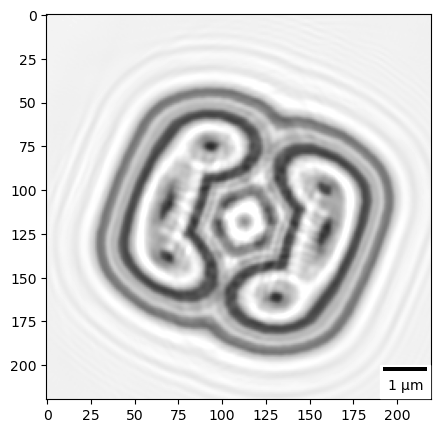

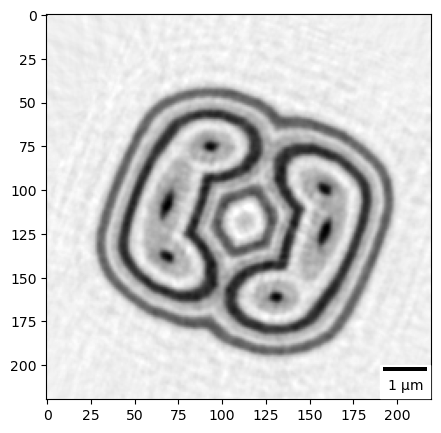

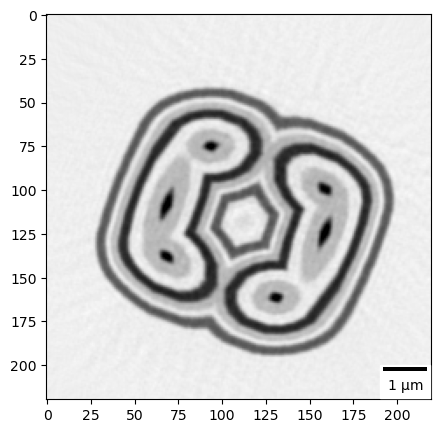

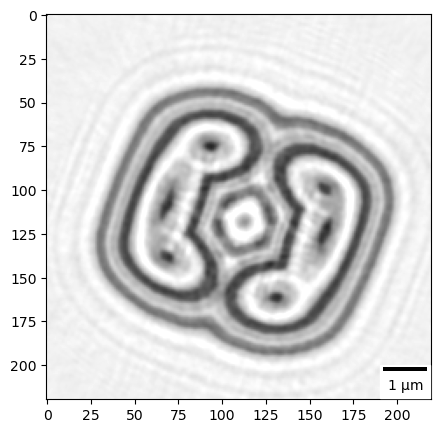

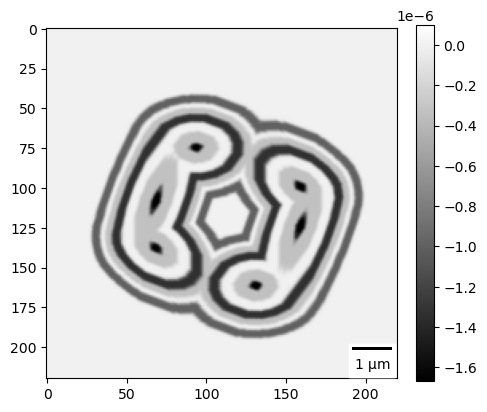

In [8]:
[n,ne] = rec_admm.shape[:2]
crop = [15,20,64,100]

shift = +1
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_nocode[n//2,crop[2]:-crop[3], crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs2/recnocode.png',dpi=300,bbox_inches='tight')

crop = [15,20,64,100]
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_admm[n//2,crop[2]:-crop[3], crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs2/recadmm.png',dpi=300,bbox_inches='tight')

crop = [15,20,64,100]
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_admm2[n//2,crop[2]:-crop[3], crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs2/recadmm2.png',dpi=300,bbox_inches='tight')


crop = [15,20,64,100]
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_2step[n//2,crop[2]:-crop[3], crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs2/rec2step.png',dpi=300,bbox_inches='tight')

u = np.load('data/u.npy').astype('complex64').real

crop = [15,20,64-n//4,100-n//4]
print(u.shape,n,ne)
fig, ax = plt.subplots(1, figsize=(5,5))
# u[:] = 1
# u[u.shape[0]//2:] = 2
mshow(u[n//2, crop[2]:-crop[3], crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs2/u.png',dpi=300,bbox_inches='tight')
print(np.amin(u.real))

mshow(u[n//2, crop[2]:-crop[3], crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar(fraction=0.046)
# plt.show()
plt.savefig(f'figs2/uc.png',dpi=300,bbox_inches='tight')
print(np.amin(u.real))


-1.6778321e-06
-1.6778321e-06


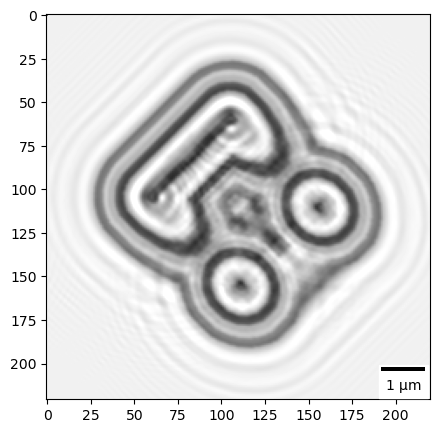

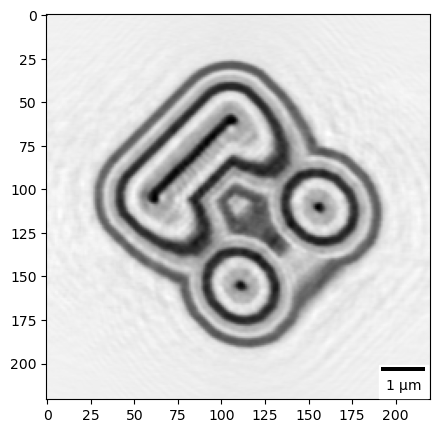

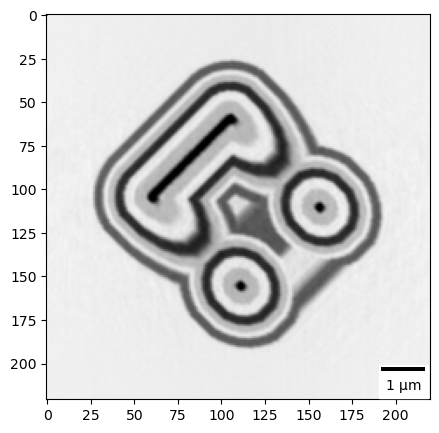

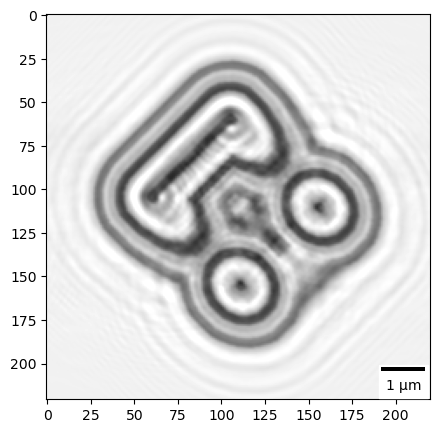

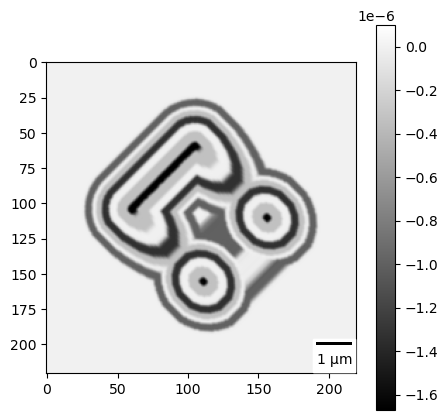

In [6]:
[n,ne] = rec_admm.shape[:2]
crop = [15,20,64,100]
shift = 3
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_nocode[crop[0]:-crop[1],ne//2+shift, crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs/recnocode.png',dpi=300,bbox_inches='tight')

crop = [15,20,64,100]
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_admm[crop[0]:-crop[1],ne//2+shift, crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs/recadmm.png',dpi=300,bbox_inches='tight')

crop = [15,20,64,100]
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_admm2[crop[0]:-crop[1],ne//2+shift, crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs/recadmm2.png',dpi=300,bbox_inches='tight')


crop = [15,20,64,100]
fig, ax = plt.subplots(1, figsize=(5,5))
mshow(rec_2step[crop[0]:-crop[1],ne//2+shift, crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs/rec2step.png',dpi=300,bbox_inches='tight')

u = np.load('data/u.npy').astype('complex64').real

crop = [15,20,64-n//4,100-n//4]
fig, ax = plt.subplots(1, figsize=(5,5))
# u[:] = 1
# u[u.shape[0]//2:] = 2
mshow(u[crop[0]:-crop[1],n//2+shift, crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
# plt.colorbar()
# plt.show()
plt.savefig(f'figs/u.png',dpi=300,bbox_inches='tight')
print(np.amin(u.real))

mshow(u[crop[0]:-crop[1],n//2+shift, crop[2]:-crop[3]],cmap='gray',vmin=vvmin,vmax=vvmax)
ax.add_artist(ScaleBar(voxelsize,location='lower right'))
plt.colorbar(fraction=0.046,)
# plt.show()
plt.savefig(f'figs/uc.png',dpi=300,bbox_inches='tight')
print(np.amin(u.real))

